In [1]:
!ls data/*/*.csv

data/McGill-Billboard/billboard-2.0-index.csv


In [2]:
import pandas as pd
df = pd.read_csv('data/McGill-Billboard/billboard-2.0-index.csv')
df.head()

,id,chart_date,target_rank,actual_rank,title,artist,peak_rank,weeks_on_chart
0,1,1987-07-11,82,NaN,NaN,NaN,NaN,NaN
1,2,1973-08-04,14,NaN,NaN,NaN,NaN,NaN
2,3,1961-07-03,56,57.0,I Don't Mind,James Brown,47.0,8.0
3,4,1971-08-07,32,31.0,You've Got A Friend,"Roberta Flack,Donny Hathaway",29.0,12.0
4,5,1976-07-10,51,NaN,NaN,NaN,NaN,NaN


In [29]:
# check date range of songs
years = pd.DatetimeIndex(df.chart_date).year
print(f'{years.min()}-{years.max()}')

1958-1991


In [3]:
# for our application we're only interested in ID, title, and artist
df_songs = df[df.title.notnull() & df.artist.notnull()][['id', 'title', 'artist']]
df_songs.head()

,id,title,artist
2,3,I Don't Mind,James Brown
3,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
5,6,The Rose,Bette Midler
9,10,An Innocent Man,Billy Joel
11,12,Lookin' For Love,Johnny Lee


In [18]:
# check duplicates
dups = df_songs[df_songs.duplicated(subset=['title','artist'], keep=False)]
dups.head()

,id,title,artist
3,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
5,6,The Rose,Bette Midler
15,16,She Bop,Cyndi Lauper
22,23,And She Was,Talking Heads
28,29,The Joker,Steve Miller Band


#### Check available features

In [4]:
base_dir = 'data/McGill-Billboard'
sample_dir = f'{base_dir}/0003'
!ls {sample_dir} -l

total 812
-rw-rw-r-- 1 cjbayron cjbayron 580969 Aug  2  2013 bothchroma.csv
-rw-rw-r-- 1 cjbayron cjbayron 221942 Aug  2  2013 echonest.json
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 full.lab
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 majmin7inv.lab
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 majmin7.lab
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 majmininv.lab
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 majmin.lab
-rw-rw-r-- 1 cjbayron cjbayron     62 Aug  2  2013 tuning.csv


In [11]:
!cat {sample_dir}/tuning.csv

"/tmp/audio.wav",0.000000000,151.022585034,441.452,"441,5 Hz"


In [26]:
!cat {sample_dir}/majmin7.lab | head -n 5

0.0	7.3469387e-2	N
7.3469387e-2	1.51356009	N
1.51356009	1.8015782305999999	N
1.8015782305999999	3.529687074200001	A:min
3.529687074200001	5.257795917800002	A:min


In [27]:
!cat {sample_dir}/bothchroma.csv | head -n 5

"/tmp/audio.wav",0.000000000,0.198482,0,0,0.635556,0.741292,1.0043,0.81444,0.0292819,0.141189,0.80793,0.91015,0.823603,1.22066,0.0969013,0.197437,0.860228,1.16515,1.13561,0.42842,0.112475,1.49297,0.556156,0.562561,0.864485
,0.046439909,0.310882,0,0,0.693876,0.628553,1.08004,0.676368,0.0175979,0.140079,0.927873,0.663851,0.460197,1.16061,0.306418,0.39068,0.939165,1.05337,1.30823,0.32271,0.0675953,1.53804,0.566076,0.627636,0.904673
,0.092879818,0.404969,0,0.0372381,0.68277,0.59114,1.14683,0.575229,0.0146243,0.128743,0.968012,0.461634,0.260265,1.18625,0.357235,0.392881,0.924133,0.946938,1.36967,0.23419,0.0561735,1.42935,0.532472,0.686886,0.906338
,0.139319727,0.480218,0,0.00500218,0.435639,0.450297,1.21112,0.458671,0.00637153,0.102629,0.962884,0.301896,0.257244,1.08408,0.395586,0.323281,0.917475,0.679013,1.48532,0.186736,0.0244738,1.22717,0.529464,0.717978,1.05768
,0.185759637,0.539064,0.146614,0.0108908,0.444361,0.196939,1.29815,0.239054,0.0233052,0.20809,0.948395,0.0258015,0.341731,0.945

In [47]:
# check if duplicates are exact match
NUM_CHECKS = 5
for ix in dups.index[:NUM_CHECKS]:
    row = dups.loc[ix]
    ids = df_songs[(df_songs.title == row.title)
                   & (df_songs.artist == row.artist)].id.values
    
    ref_id = ids[0]
    dirname = f'{base_dir}/{ref_id:04d}'
    with open(f'{dirname}/tuning.csv', 'r') as f:
        ref_tuning = f.read()
    
    with open(f'{dirname}/majmin7.lab', 'r') as f:
        ref_chords = f.read()
        
    with open(f'{dirname}/bothchroma.csv', 'r') as f:
        ref_chroma = f.read()
    
    for _id in ids[1:]:
        dirname = f'{base_dir}/{_id:04d}'
        with open(f'{dirname}/tuning.csv', 'r') as f:
            tuning = f.read()
        
        with open(f'{dirname}/majmin7.lab', 'r') as f:
            chords = f.read()
        
        with open(f'{dirname}/bothchroma.csv', 'r') as f:
            chroma = f.read()
        
        print(f'{_id:04d} to {ref_id:04d} [tuning]: {ref_tuning == tuning}')
        print(f'{_id:04d} to {ref_id:04d} [chords]: {ref_chords == chords}')
        print(f'{_id:04d} to {ref_id:04d} [chroma]: {ref_chroma == chroma}')
        print()

1229 to 0004 [tuning]: True
1229 to 0004 [chords]: True
1229 to 0004 [chroma]: True

1271 to 0006 [tuning]: True
1271 to 0006 [chords]: True
1271 to 0006 [chroma]: True

1274 to 0016 [tuning]: True
1274 to 0016 [chords]: True
1274 to 0016 [chroma]: True

0870 to 0023 [tuning]: True
0870 to 0023 [chords]: True
0870 to 0023 [chroma]: True

0504 to 0029 [tuning]: True
0504 to 0029 [chords]: True
0504 to 0029 [chroma]: True



This builds the confidence that we can just remove duplicates.

In [5]:
# we remove duplicated songs (except first occurrence)
unique_filter = ~df_songs.duplicated(subset=['title','artist'], keep='first')
df_songs_unique = df_songs[unique_filter]
print(len(df_songs_unique))
df_songs_unique.head()

742


,id,title,artist
2,3,I Don't Mind,James Brown
3,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
5,6,The Rose,Bette Midler
9,10,An Innocent Man,Billy Joel
11,12,Lookin' For Love,Johnny Lee


In [6]:
# check again
any(df_songs_unique.duplicated(subset=['title', 'artist']))

False

In [8]:
df_songs_unique.to_csv(f'{base_dir}/billboard-2.0-unique.csv', index=False)

#### Pick songs for feature analysis

In [1]:
import pandas as pd
base_dir = 'data/McGill-Billboard'
data_index = 'billboard-2.0-unique.csv'

df_songs_unique = pd.read_csv(f'{base_dir}/{data_index}')
df_songs_unique.head()

,id,title,artist
0,3,I Don't Mind,James Brown
1,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
2,6,The Rose,Bette Midler
3,10,An Innocent Man,Billy Joel
4,12,Lookin' For Love,Johnny Lee


In [2]:
df_songs_unique.tail()

,id,title,artist
737,1286,Sukiyaki,A Taste Of Honey
738,1287,Johnny Reb,Johnny Horton
739,1289,There She Goes,The La's
740,1290,Happy Together,The Turtles
741,1292,He's So Fine,The Chiffons


In [2]:
df_songs_unique[df_songs_unique.title.str.contains("kiss", case=False)]

,id,title,artist
7,18,Kiss On My List,Daryl Hall & John Oates
31,54,Last Kiss,J. Frank Wilson & The Cavaliers
171,263,Last Kiss,Wednesday
238,370,Kisses On The Wind,Neneh Cherry
302,478,One Last Kiss,The J. Geils Band
511,856,I Like The Way (The Kissing Game),Hi-Five


In [94]:
df_songs_unique.artist.sample(n=10)

124         The O'Jays
436         Commodores
605    Aretha Franklin
621               Dion
270    George Harrison
4           Johnny Lee
493       Bill Withers
338        The Trammps
363              Queen
557             Boston
Name: artist, dtype: object

In [1]:
# after going around the list, picked the following:

# - 1289 - There She Goes - The La's
# - 736 - Do I Do - Stevie Wonder
# - 637 - Human Nature - Michael Jackson
# - 270 - In My Room - The Beach Boys
# - 18 - Kiss On My List - Daryl Hall & John Oates

picked_ids = [1289, 736, 637, 270, 18]

We download these songs to analyse if we can extract chroma features closely similar to those provided by dataset.

In [20]:
# check duration
for _id in picked_ids:
    tuning = f'{base_dir}/{_id:04d}/tuning.csv'
    title = df_songs_unique[df_songs_unique.id == _id].iloc[0].title
    contents = pd.read_csv(tuning, header=None)
    duration = contents[2].iloc[0]
    print(f'{title}: {duration:.2f}s, {int(duration/60)}:{int(duration%60.0):02d}')

There She Goes: 162.54s, 2:42
Do I Do: 629.17s, 10:29
Human Nature: 245.76s, 4:05
In My Room: 134.68s, 2:14
Kiss On My List: 231.27s, 3:51


In [6]:
# convert mp3 to wav
from glob import glob
import codecs

for _id in picked_ids:
    mp3_pattern = f'data/audio/{_id:04d}/*.mp3'
    mp3_list = glob(mp3_pattern)
    if len(mp3_list) == 0:
        print(f'{_id}: Missing MP3')
        continue

    mp3_fn = f'"{mp3_list[0]}"'
    audio_fn = f'data/audio/{_id:04d}/audio.wav'
    print(mp3_fn, audio_fn)
    
    !ffmpeg -y -i {mp3_fn} {audio_fn}

"data/audio/0736/Do I Do.mp3" data/audio/0736/audio.wav
ffmpeg version 2.8.17-0ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.12) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libs

size=   42652kB time=00:04:07.59 bitrate=1411.2kbits/s    
video:0kB audio:42652kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000179%
"data/audio/0270/Beach Boys-In My Room.mp3" data/audio/0270/audio.wav
ffmpeg version 2.8.17-0ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.12) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-

size=   39744kB time=00:03:50.71 bitrate=1411.2kbits/s    
video:0kB audio:39744kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000192%


#### Chroma feature analysis

In [7]:
def load_billboard_chroma(_id):
    """ Load bothchroma(bass-treble) vectors from Billboard dataset """
    
    fn = f'{base_dir}/{_id:04d}/bothchroma.csv'
    contents = pd.read_csv(fn, header=None)
    
    # we only get 3rd column onwards
    # (first column empty, 2nd column time tick)
    bothchroma = contents[contents.columns[2:]].values
    return bothchroma
    
# chroma_samp = load_billboard_chroma(1289)
# chroma_samp.shape

In [8]:
from scipy.signal import resample
import librosa
import vamp
import torch
from torchaudio.transforms import Resample

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [9]:
_SAMPLE_RATE = 44100
def generate_chroma(_id, resampler='scipy', params={}):
    """ Generate chroma from raw audio """
    
    audio_fn = f'data/audio/{_id:04d}/audio.wav'
    X, fs = librosa.load(audio_fn, sr=None, mono=True)
    if fs != _SAMPLE_RATE:
        if resampler == 'scipy':
            X = resample(X, num=int(len(X)*_SAMPLE_RATE/fs))
        elif resampler == 'torch':
            resampling_transform = Resample(orig_freq=fs,
                                            new_freq=_SAMPLE_RATE)
            X = resampling_transform(torch.Tensor([X])).squeeze().numpy()
        else:
            raise Exception('unsupported resampler')
    
    out = vamp.collect(X, _SAMPLE_RATE, 'nnls-chroma:nnls-chroma',
                       output='bothchroma', parameters=params)
    chroma = out['matrix'][1]
    return chroma

# chroma_gen = generate_chroma(1289)
# chroma_gen.shape

# chroma_gen = generate_chroma(1289, resampler='torch')
# chroma_gen.shape

In [26]:
from librosa.sequence import dtw

print('**Feature comparison scores: (lower, better)**')
for ix, _id in enumerate(picked_ids):
    _, fs = librosa.load(audio_fn, sr=None, mono=True)
    print(f'{df_songs_unique[df_songs_unique.id == _id].iloc[0].title} ({fs} Hz)')
    chroma_samp = load_billboard_chroma(_id)
    
    if ix == 0:
        ref_id = picked_ids[-1]
    else:
        ref_id = picked_ids[ix-1]
        
    chroma_gen = generate_chroma(ref_id)
    D, wp = dtw(chroma_samp.T, chroma_gen.T, subseq=True)
    print(f'- baseline {_id} vs. {ref_id}: {D[-1,-1]}, ({(D[-1,-1]/len(wp)):.4f})')
    
    chroma_gen = generate_chroma(_id)
    D, wp = dtw(chroma_samp.T, chroma_gen.T, subseq=True)
    print(f'- default params: {D[-1,-1]}, ({(D[-1,-1]/len(wp)):.4f})')
          
    chroma_gen = generate_chroma(_id, params={'rollon': 1.0})
    D, wp = dtw(chroma_samp.T, chroma_gen.T, subseq=True)
    print(f'- rollon=1.0: {D[-1,-1]}, ({(D[-1,-1]/len(wp)):.4f})')
    
    chroma_gen = generate_chroma(_id, resampler='torch')
    D, wp = dtw(chroma_samp.T, chroma_gen.T, subseq=True)
    print(f'- (torch) default params: {D[-1,-1]}, ({(D[-1,-1]/len(wp)):.4f})')
          
    chroma_gen = generate_chroma(_id, resampler='torch', params={'rollon': 1.0})
    D, wp = dtw(chroma_samp.T, chroma_gen.T, subseq=True)
    print(f'- (torch) rollon=1.0: {D[-1,-1]}, ({(D[-1,-1]/len(wp)):.4f})')

**Feature comparison scores: (lower, better)**
There She Goes (44100 Hz)
- baseline 1289 vs. 18: 12029.508463859287, (3.4390)
- default params: 2445.9897979354173, (0.6975)
- rollon=1.0: 1607.4430335601976, (0.4576)
- (torch) default params: 2445.9897979354173, (0.6975)
- (torch) rollon=1.0: 1607.4430335601976, (0.4576)


#### Results

**Feature comparison scores: (lower, better) - DTW using euclidean**

There She Goes (44100 Hz)
- baseline 1289 vs. 18: 12029.508463859287, (3.4390)
- default params: 2445.9897979354173, (0.6975)
- rollon=1.0: 1607.4430335601976, (0.4576)
- (torch) default params: 2445.9897979354173, (0.6975)
- (torch) rollon=1.0: 1607.4430335601976, (0.4576)

Do I Do (44100 Hz)
- baseline 736 vs. 1289: 12908.893054462502, (3.6935)
- default params: 10232.603308441066, (0.7540)
- rollon=1.0: 7959.5899138883005, (0.5855)
- (torch) default params: 10232.603308441066, (0.7540)
- (torch) rollon=1.0: 7959.5899138883005, (0.5855)

Human Nature (44100 Hz)
- baseline 637 vs. 736: 19035.009415674383, (3.5983)
- default params: 4281.003677918029, (0.8062)
- rollon=1.0: 2319.672082818038, (0.4342)
- (torch) default params: 4281.003677918029, (0.8062)
- (torch) rollon=1.0: 2319.672082818038, (0.4342)

In My Room (44100 Hz)
- baseline 270 vs. 637: 11444.917424275756, (3.9492)
- default params: 2151.226360052589, (0.7454)
- rollon=1.0: 798.4747727709864, (0.2764)
- (torch) default params: 2151.226360052589, (0.7454)
- (torch) rollon=1.0: 798.4747727709864, (0.2764)

Kiss On My List (44100 Hz)
- baseline 18 vs. 270: 12711.067976921897, (4.4105)
- default params: 5958.371894469859, (1.1938)
- rollon=1.0: 5176.020856636849, (1.0311)
- (torch) default params: 5958.371894469859, (1.1938)
- (torch) rollon=1.0: 5176.020856636849, (1.0311)

#### Prep for loading the data

In [1]:
import pandas as pd
base_dir = 'data/McGill-Billboard'
data_index = 'billboard-2.0-unique.csv'

In [2]:
df_songs = pd.read_csv(f'{base_dir}/{data_index}')
df_songs.head()

,id,title,artist
0,3,I Don't Mind,James Brown
1,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
2,6,The Rose,Bette Midler
3,10,An Innocent Man,Billy Joel
4,12,Lookin' For Love,Johnny Lee


In [3]:
len(df_songs)

742

In [8]:
!ls {base_dir}/1289

bothchroma.csv	full.lab	majmin7.lab    majmin.lab
echonest.json	majmin7inv.lab	majmininv.lab  tuning.csv


In [11]:
!tail {base_dir}/1289/bothchroma.csv

,161.982403628,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.028843537,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.075283446,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.121723356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.168163265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.214603174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.261043083,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.307482993,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.353922902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,162.400362811,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
def get_chroma_matrix(_id, return_timestamps=False):
    """ Load bothchroma(bass-treble) vectors from Billboard dataset """
    
    fn = f'{base_dir}/{_id:04d}/bothchroma.csv'
    contents = pd.read_csv(fn, header=None)
    
    # we only get 3rd column onwards
    # (first column empty, 2nd column time tick)
    bothchroma = contents[contents.columns[2:]].values
    if not return_timestamps:
        return bothchroma
    
    start_times = contents[contents.columns[1]].values
    step_size = start_times[1]
    end_times = np.append(start_times[1:], [start_times[-1]+step_size], axis=0)
    timestamps = np.vstack((start_times, end_times)).T
    return timestamps, bothchroma

In [33]:
get_chroma_matrix(1289).shape # num frames, chroma feature size

(3498, 24)

In [34]:
ts, cmatrix = get_chroma_matrix(1289, return_timestamps=True)
print(ts.shape, cmatrix.shape)

(3498, 2) (3498, 24)


From reading bothchroma and chroma feature comparison:

- sample rate: **44100 Hz**
- step size for each chroma vector: 0.046439909s or **~50ms**
    - equivalent to 0.046439909 * 44100 = **~2048 samples**

In [11]:
lab_fn = f'{base_dir}/1289/majmin.lab'
!head {lab_fn}

0.0	0.325079365	N
0.325079365	1.3641723354999997	G:maj
1.3641723355000002	2.4032653059999998	D:maj
2.4032653060000007	4.481451247000001	C:maj
4.481451247000002	5.520544217500001	G:maj
5.520544217500002	6.559637188000002	D:maj
6.559637188000003	8.118276643750002	C:maj
8.118276643750004	8.637823129000003	D:maj
8.637823129	9.634569160749999	G:maj
9.634569160749999	10.631315192499999	D:maj


In [4]:
import mir_eval

def get_chord_labels(_id, label_type='majmin'):
    """ Load chord labels from .LAB files
    
    label_type: majmin, majmin7, majmininv, majmin7inv, full
    """
    lab_fn = f'{base_dir}/{_id:04d}/{label_type}.lab'
    # any line starting w/ \n is ignored e.g. blank lines
    timestamps, chord_labels = mir_eval.io.load_labeled_intervals(lab_fn, comment='\n')
    return timestamps, chord_labels

In [5]:
timestamps, chord_labels = get_chord_labels(1289)
for ix, (ts, lab) in enumerate(zip(timestamps, chord_labels)):
    print(ts, lab)
    if ix == 5:
        break

[0.         0.32507937] N
[0.32507937 1.36417234] G:maj
[1.36417234 2.40326531] D:maj
[2.40326531 4.48145125] C:maj
[4.48145125 5.52054422] G:maj
[5.52054422 6.55963719] D:maj


Now we have to map EACH chroma vector to these labels.

Considerations:
* *Time steps of vectors does not match time steps in labels* - for first iteration, we can **ignore** chroma vectors spanning multiple labels / occuring at chord transitions
* *Numerical representation of chords* - `mir_eval.chords.encode()` converts chord labels to (semitone, quality (maj,min,etc.); for first iteration, we **limit to majmin and "squash" both semitone and quality in a single label**. We also **add 1** to the representation to shift -1 encoding for N (no chord) to 0

Before we perform actual encoding of labels, let's perform some checks first.

In [83]:
from tqdm import tqdm

majmin_chordset = set()
majmin7_chordset = set()

for _id in tqdm(df_songs.id):
    _, chord_labels = get_chord_labels(_id, label_type='majmin')
    majmin_chordset.update(chord_labels)
    
    _, chord_labels = get_chord_labels(_id, label_type='majmin7')
    majmin7_chordset.update(chord_labels)

100%|██████████| 742/742 [00:00<00:00, 809.76it/s]


In [93]:
temp = list(majmin_chordset)
temp.sort()
print(temp)

['A#:maj', 'A:maj', 'A:min', 'Ab:maj', 'Ab:min', 'B:maj', 'B:min', 'Bb:maj', 'Bb:min', 'C#:maj', 'C#:min', 'C:maj', 'C:min', 'Cb:maj', 'Cb:min', 'D#:maj', 'D#:min', 'D:maj', 'D:min', 'Db:maj', 'Db:min', 'E:maj', 'E:min', 'Eb:maj', 'Eb:min', 'F#:maj', 'F#:min', 'F:maj', 'F:min', 'Fb:maj', 'G#:maj', 'G#:min', 'G:maj', 'G:min', 'Gb:maj', 'Gb:min', 'N', 'X']


In [94]:
temp = list(majmin7_chordset)
temp.sort()
print(temp)

['A#:maj', 'A:7', 'A:maj', 'A:maj7', 'A:min', 'A:min7', 'Ab:7', 'Ab:maj', 'Ab:maj7', 'Ab:min', 'Ab:min7', 'B:7', 'B:maj', 'B:maj7', 'B:min', 'B:min7', 'Bb:7', 'Bb:maj', 'Bb:maj7', 'Bb:min', 'Bb:min7', 'C#:7', 'C#:maj', 'C#:min', 'C#:min7', 'C:7', 'C:maj', 'C:maj7', 'C:min', 'C:min7', 'Cb:7', 'Cb:maj', 'Cb:maj7', 'Cb:min', 'D#:7', 'D#:maj', 'D#:min', 'D#:min7', 'D:7', 'D:maj', 'D:maj7', 'D:min', 'D:min7', 'Db:7', 'Db:maj', 'Db:maj7', 'Db:min', 'Db:min7', 'E:7', 'E:maj', 'E:maj7', 'E:min', 'E:min7', 'Eb:7', 'Eb:maj', 'Eb:maj7', 'Eb:min', 'Eb:min7', 'F#:7', 'F#:maj', 'F#:min', 'F#:min7', 'F:7', 'F:maj', 'F:maj7', 'F:min', 'F:min7', 'Fb:maj', 'Fb:maj7', 'G#:7', 'G#:maj', 'G#:min', 'G#:min7', 'G:7', 'G:maj', 'G:maj7', 'G:min', 'G:min7', 'Gb:7', 'Gb:maj', 'Gb:maj7', 'Gb:min', 'Gb:min7', 'N', 'X']


Looks good. We can interpret X and N as same class.

In [113]:
for _id in tqdm(df_songs.id):
    ts, _ = get_chord_labels(_id)
    # check if intervals are contiguous
    assert(sum(ts[:-1, 1] - ts[1:, 0]) < 1e-9)
    # check if time values are all positive
    assert((ts >= 0.0).all())

100%|██████████| 742/742 [00:00<00:00, 1556.25it/s]


Looks good. We now proceed to encoding the labels.

In [5]:
import numpy as np

# bitmaps of chord qualities
_MAJ_BITMAP = mir_eval.chord.quality_to_bitmap('maj')
_MIN_BITMAP = mir_eval.chord.quality_to_bitmap('min')
_MAJ7_BITMAP = mir_eval.chord.quality_to_bitmap('maj7')
_MIN7_BITMAP = mir_eval.chord.quality_to_bitmap('min7')

_NUM_SEMITONE = 12

def encode_chords_single_label(chord_labels):
    """ Encode chord labels to a single label (semitone/root, quality in one) """
    
    # third array is bass number, which we ignore
    root_classes, quality_classes, _ = mir_eval.chord.encode_many(chord_labels)
    root_classes += 1 # add 1 to shift No Chord (-1) to 0

    min_chords_filt = np.all(quality_classes == _MIN_BITMAP, axis=1)
    maj7_chords_filt = np.all(quality_classes == _MAJ7_BITMAP, axis=1)
    min7_chords_filt = np.all(quality_classes == _MIN7_BITMAP, axis=1)

    root_classes[min_chords_filt] += _NUM_SEMITONE
    root_classes[maj7_chords_filt] += _NUM_SEMITONE*2
    root_classes[min7_chords_filt] += _NUM_SEMITONE*3

    return root_classes

chord_classes = encode_chords_single_label(get_chord_labels(1289)[1])
chord_classes[:5]

array([0, 8, 3, 1, 8])

In [140]:
# similar check from last time; this time the encodings are checked
from tqdm import tqdm

majmin_chordset = set()
majmin7_chordset = set()

for _id in tqdm(df_songs.id):
    _, chord_labels = get_chord_labels(_id, label_type='majmin')
    majmin_chordset.update(encode_chords_single_label(chord_labels))
    
    _, chord_labels = get_chord_labels(_id, label_type='majmin7')
    majmin7_chordset.update(encode_chords_single_label(chord_labels))

100%|██████████| 742/742 [00:01<00:00, 547.63it/s]


In [141]:
temp = list(majmin_chordset)
temp.sort()
print(temp)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [142]:
temp = list(majmin7_chordset)
temp.sort()
print(temp)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


Looks great! We can proceed to matching the chroma vectors and these labels for model training.

In [6]:
import numpy as np

def get_chord_features_and_labels(_id):
    """ Get chroma vectors and chord labels """
    chroma_timestamps, chroma_vectors = get_chroma_matrix(_id, return_timestamps=True)
    chord_timestamps, chord_labels_str = get_chord_labels(_id)
    chord_labels = encode_chords_single_label(chord_labels_str)

    assert(len(chroma_timestamps) == len(chroma_vectors))
    assert(len(chord_timestamps) == len(chord_labels))

    # label for each chroma vector
    chromavec_labels = np.zeros(len(chroma_vectors)).astype(np.int)-1 # all -1's
    st_ix = 0 # lower bound for updating labels
    for i, (ts, chord_label) in enumerate(zip(chord_timestamps, chord_labels)):
        # get indices of chroma timestamps within duration of current chord
        in_cur_chord = (chroma_timestamps[st_ix:, 0] >= ts[0]) \
                        & (chroma_timestamps[st_ix:, 1] <= ts[1])
        chromavec_labels[st_ix:][in_cur_chord] = chord_label

        # update lower bound
        in_cur_chord = in_cur_chord.astype(int)
        transitions = in_cur_chord[1:] - in_cur_chord[:-1]
        # we get index of first occurence of True->False transition
        # False-True = -1
        TtoF_ixs = np.where(transitions==-1)[0]

        if len(TtoF_ixs) > 0:
            st_ix += (TtoF_ixs[0] + 1) # +1 due to offset by diffing to get transitions

    remove_ambiguous_mask = (chromavec_labels != -1)
    return chroma_vectors[remove_ambiguous_mask], chromavec_labels[remove_ambiguous_mask]

In [7]:
chroma_vectors, chord_labels = get_chord_features_and_labels(1289)

In [9]:
chroma_vectors.shape, chord_labels.shape

((3358, 24), (3358,))

In [157]:
chord_labels[:100]

array([0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8])

Now we use the feature & label extraction function on all data. (Try if we can fit all of it into memory i.e. a single NumPy array).

In [26]:
len(df_songs), chroma_vectors.nbytes, chord_labels.nbytes

(742, 644736, 26864)

In [27]:
print(f'estimate memory size: {(len(df_songs)*(chroma_vectors.nbytes+chord_labels.nbytes)/(1024*1024)):.2f} MB')

estimate memory size: 475.24 MB


In [36]:
from tqdm import tqdm

all_chroma_vectors = []
all_chord_labels = []

for _id in tqdm(df_songs.id):
    chroma_vectors, chord_labels = get_chord_features_and_labels(_id)
    
    if len(all_chroma_vectors) == 0:
        all_chroma_vectors = chroma_vectors
        all_chord_labels = chord_labels
    else:    
        all_chroma_vectors = np.concatenate((all_chroma_vectors, chroma_vectors))
        all_chord_labels = np.concatenate((all_chord_labels, chord_labels))

 77%|███████▋  | 569/742 [00:59<00:30,  5.63it/s]/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/mir_eval/io.py:281: UserWarning: All interval durations must be strictly positive
  warnings.warn(error.args[0])
100%|██████████| 742/742 [01:33<00:00,  7.93it/s]


In [ ]:
# check 569?

In [39]:
print(f'actual memory size: {((all_chroma_vectors.nbytes+all_chord_labels.nbytes)/(1024*1024)):.2f} MB')

actual memory size: 640.97 MB


In [40]:
np.save('data/01_all_chroma_vectors.npy', all_chroma_vectors)
np.save('data/01_all_chord_labels.npy', all_chord_labels)

In [41]:
all_chroma_vectors.shape, all_chord_labels.shape

((3360513, 24), (3360513,))

With this data, we can proceed to first training iteration.

#### Feature check

In [2]:
import numpy as np
from scipy.signal import resample
import librosa
import vamp

_SAMPLE_RATE = 44100
def generate_chroma_from_wav(audio_fn, params={'rollon': 1.0}):
    """ Generate chroma from raw audio """
    
    X, fs = librosa.load(audio_fn, sr=None, mono=True)
    if fs != _SAMPLE_RATE:
        X = resample(X, num=int(len(X)*_SAMPLE_RATE/fs))
        
    out = vamp.collect(X, _SAMPLE_RATE, 'nnls-chroma:nnls-chroma',
                       output='bothchroma', parameters=params)
    
    chroma = out['matrix'][1]
    return chroma

(151, 24)


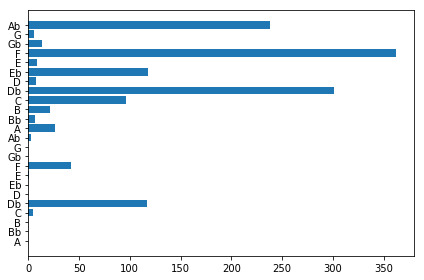

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

#notes = ['C','Db','D','Eb','E','F','Gb','G','Ab','A','Bb','B'] # this is WRONG!!!!
notes = ['A','Bb','B', 'C','Db','D','Eb','E','F','Gb','G','Ab']
cmx = generate_chroma_from_wav('data/freesound/c_major.wav')
print(cmx.shape)
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

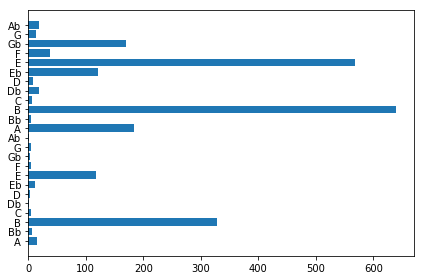

In [27]:
cmx = generate_chroma_from_wav('data/freesound/a_major.wav')
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

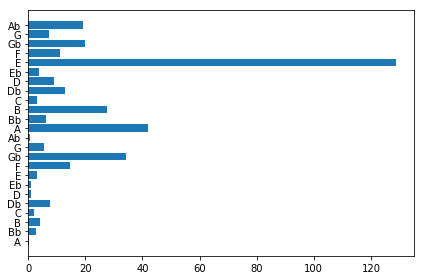

In [28]:
cmx = generate_chroma_from_wav('data/freesound/e4.wav')
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


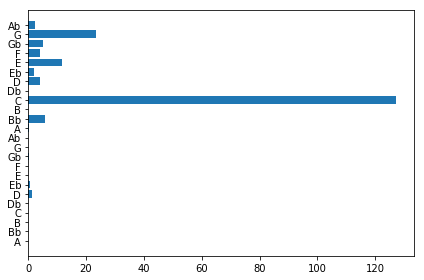

In [29]:
cmx = generate_chroma_from_wav('data/freesound/c.m4a')
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


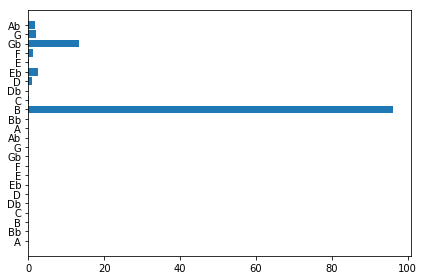

In [30]:
cmx = generate_chroma_from_wav('data/freesound/b.m4a')
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

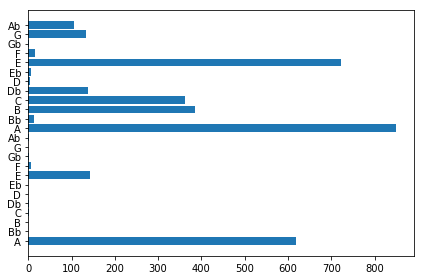

In [31]:
cmx = generate_chroma_from_wav('data/freesound/a_minor.wav')
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

Realizations from here:
- Chordino bothchroma is intepreted as: [0:12], [12:24] -> [A up to Ab], bass, treble
- Chordino output can have "incorrect" chroma values (perhaps due to tuning issues...) e.g. C maj interpreted as Dbmaj
    - BUT, the quality of the chord is retained
    - Also try to visualize each individual vector (instead of only mean/sum) to confirm

In [4]:
# try on a larger scale
all_chroma_vectors = np.load('data/01_all_chroma_vectors.npy')
all_chord_labels = np.load('data/01_all_chord_labels.npy')
all_chroma_vectors.shape, all_chord_labels.shape

((3360513, 24), (3360513,))

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


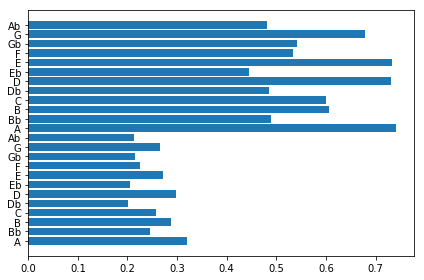

In [5]:
filt = [all_chord_labels == 0] # no chord
plt.barh(range(24), np.mean(all_chroma_vectors[filt], axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


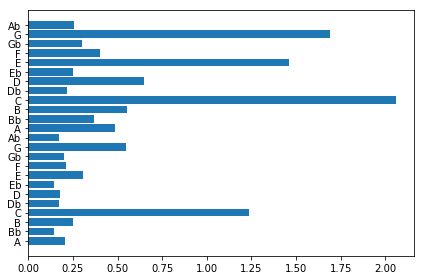

In [6]:
filt = [all_chord_labels == 1] # c maj
plt.barh(range(24), np.mean(all_chroma_vectors[filt], axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


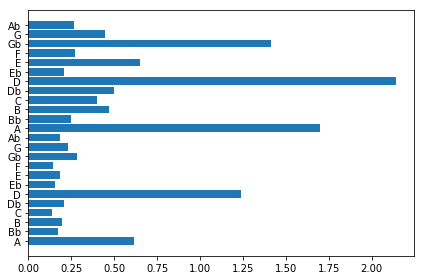

In [7]:
filt = [all_chord_labels == 3] # d maj
plt.barh(range(24), np.mean(all_chroma_vectors[filt], axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

/home/cjbayron/virtualenvs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


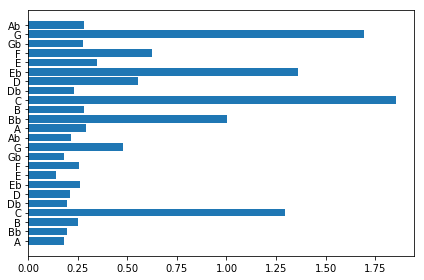

In [39]:
filt = [all_chord_labels == 13] # c min
plt.barh(range(24), np.mean(all_chroma_vectors[filt], axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

Here we can see that the SUM of the vectors for each class "activate" appropriately at the chord class's pitch classes.

In [6]:
# automated check

import mir_eval

def encode_to_chordino_chroma(label):
    root, quality_map, _ = mir_eval.chord.encode(label)
    root = (root+3)%12 # add 3 to map to chordino chroma
    chord_bitmap = mir_eval.chord.rotate_bitmap_to_root(quality_map, root) 
    return root, chord_bitmap
    
encode_to_chordino_chroma('A:maj')

(0, array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]))

In [7]:
# from importlib import reload
# import dataloader
# reload(dataloader)

from dataloader import _CHROMA_FEAT_NAMES, SimpleChromaDataset

for class_index, chord_name in enumerate(SimpleChromaDataset._MAJMIN_CLASSES):
    if class_index == 0:
        continue
    
    root, chord_bitmap = encode_to_chordino_chroma(chord_name)
    filt = (all_chord_labels == class_index)
    vector_mean = np.mean(all_chroma_vectors[filt], axis=0)
    
    vector_topk = set(np.argpartition(vector_mean[12:], -3)[-3:])
    bitmap_topk = set(np.argpartition(chord_bitmap, -3)[-3:])
    
    bass_match = (root == np.argmax(vector_mean[:12]))
    chord_match = (vector_topk == bitmap_topk)
    if (not bass_match) or (not chord_match):
        print(f'{chord_name} - Bass match: {bass_match} - '
              f'Chord match: {chord_match}')

In [8]:
# now check individual vectors

# N.B. add to lazycats
import numpy as np
def top_k_indices(arr, k, axis=1):
    if axis != 1:
        raise NotImplementedError
    
    temp = np.array(arr) # copy
    top_k_ixs = []
    for _ in range(k): # no checking if k > (array length along axis of argmax)
        max_ixs = np.argmax(temp, axis=axis)
        top_k_ixs.append(max_ixs)
        temp[(range(len(temp)), max_ixs)] = -np.inf # remove from next comparison
    
    top_k_ixs = np.hstack([np.array([ixs]).T for ixs in top_k_ixs])
    return top_k_ixs

In [50]:
from collections import Counter
for class_index, chord_name in enumerate(SimpleChromaDataset._MAJMIN_CLASSES):
    if class_index == 0:
        continue
    
    root, chord_bitmap = encode_to_chordino_chroma(chord_name)
    filt = (all_chord_labels == class_index)
    
    vecs = all_chroma_vectors[filt]
    basses = np.argmax(vecs[:, :12], axis=1)
    bass_match = np.mean(basses == root)*100
    ext_bass_match = bass_match + np.mean(basses == (root-1)%12)*100
    ext_bass_match += np.mean(basses == (root+1)%12)*100
    
    
    # get only on treble
    vec_ixs = top_k_indices(vecs[:, 12:], 4, axis=1)
    label_ixs = np.where(chord_bitmap)[0]
    chord_match = np.mean(np.all(np.isin(vec_ixs[:, :3], label_ixs), axis=1))
    ext_match = np.mean((np.sum(np.isin(vec_ixs, label_ixs), axis=1))==3) # ext chord
    
    print(f'{chord_name} - Bass match: {bass_match:.2f} - Ext bass match: {ext_bass_match:.2f} - '
          f'Chord match: {chord_match:.2f} - Ext match: {ext_match:.2f}')
    #print(Counter(basses))

C:maj - Bass match: 52.99 - Ext bass match: 58.20 - Chord match: 0.40 - Ext match: 0.57
Db:maj - Bass match: 49.61 - Ext bass match: 56.64 - Chord match: 0.36 - Ext match: 0.53
D:maj - Bass match: 51.69 - Ext bass match: 56.31 - Chord match: 0.39 - Ext match: 0.56
Eb:maj - Bass match: 49.59 - Ext bass match: 56.51 - Chord match: 0.31 - Ext match: 0.48
E:maj - Bass match: 54.99 - Ext bass match: 59.73 - Chord match: 0.40 - Ext match: 0.56
F:maj - Bass match: 48.83 - Ext bass match: 55.03 - Chord match: 0.37 - Ext match: 0.54
Gb:maj - Bass match: 53.24 - Ext bass match: 59.36 - Chord match: 0.34 - Ext match: 0.52
G:maj - Bass match: 56.00 - Ext bass match: 61.18 - Chord match: 0.39 - Ext match: 0.56
Ab:maj - Bass match: 55.28 - Ext bass match: 64.11 - Chord match: 0.34 - Ext match: 0.52
A:maj - Bass match: 56.14 - Ext bass match: 61.06 - Chord match: 0.36 - Ext match: 0.52
Bb:maj - Bass match: 52.85 - Ext bass match: 62.72 - Chord match: 0.38 - Ext match: 0.55
B:maj - Bass match: 54.70 -

Either there is a lot of mislabels or our features aren't very rich.

#### Exploring tuning

In [4]:
import pandas as pd
base_dir = 'data/McGill-Billboard'
data_index = 'billboard-2.0-unique.csv'

In [5]:
df_songs = pd.read_csv(f'{base_dir}/{data_index}')
df_songs.head()

,id,title,artist
0,3,I Don't Mind,James Brown
1,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
2,6,The Rose,Bette Midler
3,10,An Innocent Man,Billy Joel
4,12,Lookin' For Love,Johnny Lee


In [7]:
def get_tuning(_id):
    """ Load tuning data from Billboard dataset """
    
    fn = f'{base_dir}/{_id:04d}/tuning.csv'
    contents = pd.read_csv(fn, header=None)
    
    return contents

get_tuning(1289)

,0,1,2,3,4
0,/tmp/audio.wav,0.0,162.539683,440.082,"440,1 Hz"


In [10]:
from tqdm import tqdm

tunings_len = []
for _id in tqdm(df_songs.id):
    tuning_data = get_tuning(_id)
    tunings_len.append(len(tuning_data.loc[0]))
    tuning_vals

100%|██████████| 742/742 [00:01<00:00, 521.60it/s]


In [11]:
from collections import Counter
Counter(tunings_len)
# ALL tunings file are 1 line, with 5 values

Counter({5: 742})

In [22]:
tuning_data

,0,1,2,3,4
0,/tmp/audio.wav,0.0,115.728254,438.049,"438,0 Hz"


In [23]:
from scipy.signal import resample
import librosa
import vamp

_SAMPLE_RATE = 44100
def generate_tuning(_id, params={}):
    """ Generate chroma from raw audio """
    
    audio_fn = f'data/audio/{_id:04d}/audio.wav'
    X, fs = librosa.load(audio_fn, sr=None, mono=True)
    if fs != _SAMPLE_RATE:
        X = resample(X, num=int(len(X)*_SAMPLE_RATE/fs))
    
    out = vamp.collect(X, _SAMPLE_RATE, 'nnls-chroma:tuning',
                       output='tuning', parameters=params)
    return out

generate_tuning(1289, {'rollon':1.0})

{'list': [{'timestamp':  0.000000000,
   'duration':  162.353922902,
   'label': '440.1 Hz',
   'values': array([440.1019], dtype=float32)}]}

In [6]:
# https://github.com/librosa/librosa/blob/main/examples/adjust_tuning.py
def adjust_tuning(y, sr):
    '''Load audio, estimate tuning, apply pitch correction, and save.'''
    y_harm = librosa.effects.harmonic(y)

    print('Estimating tuning ... ')
    # Just track the pitches associated with high magnitude
    tuning = librosa.estimate_tuning(y=y_harm, sr=sr)

    print('{:+0.2f} cents'.format(100 * tuning))
    print('Applying pitch-correction of {:+0.2f} cents'.format(-100 * tuning))
    y_tuned = librosa.effects.pitch_shift(y, sr, -tuning)

    return y_tuned

In [7]:
def generate_tuning_from_wav(audio_fn, params={}, correct_tuning=False):
    """ Generate chroma from raw audio """
    X, fs = librosa.load(audio_fn, sr=None, mono=True)
    if fs != _SAMPLE_RATE:
        X = resample(X, num=int(len(X)*_SAMPLE_RATE/fs))
    if correct_tuning:
        X = adjust_tuning(X, _SAMPLE_RATE)
    
    out = vamp.collect(X, _SAMPLE_RATE, 'nnls-chroma:tuning',
                       output='tuning', parameters=params)
    return out

In [8]:
generate_tuning_from_wav('data/freesound/c_major.wav', params={'rollon':1.0}, correct_tuning=True)

Estimating tuning ... 
-44.00 cents
Applying pitch-correction of +44.00 cents


{'list': [{'timestamp':  0.000000000,
   'duration':  7.058866213,
   'label': '439.3 Hz',
   'values': array([439.32288], dtype=float32)}]}

In [9]:
def generate_chroma_from_wav(audio_fn, params={'rollon': 1.0}, correct_tuning=False):
    """ Generate chroma from raw audio """
    
    X, fs = librosa.load(audio_fn, sr=None, mono=True)
    if fs != _SAMPLE_RATE:
        X = resample(X, num=int(len(X)*_SAMPLE_RATE/fs))
    if correct_tuning:
        X = adjust_tuning(X, _SAMPLE_RATE)        
    out = vamp.collect(X, _SAMPLE_RATE, 'nnls-chroma:nnls-chroma',
                       output='bothchroma', parameters=params)
    
    chroma = out['matrix'][1]
    return chroma

(151, 24)


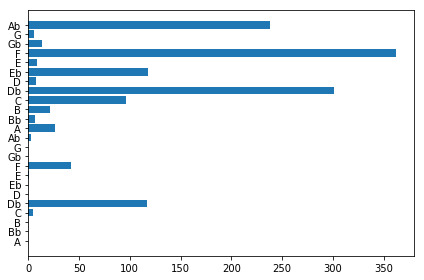

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

notes = ['A','Bb','B', 'C','Db','D','Eb','E','F','Gb','G','Ab']
cmx = generate_chroma_from_wav('data/freesound/c_major.wav', correct_tuning=False)
print(cmx.shape)
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

Estimating tuning ... 
-44.00 cents
Applying pitch-correction of +44.00 cents
(151, 24)


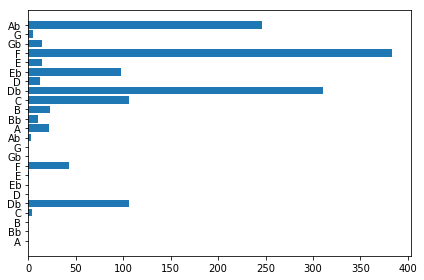

In [34]:
cmx = generate_chroma_from_wav('data/freesound/c_major.wav', correct_tuning=True)
print(cmx.shape)
plt.barh(range(24), np.sum(cmx,axis=0))
plt.yticks(range(24), notes+notes)
plt.tight_layout()

In [ ]:
# tuning doesn't seem to do much

#### Exploring temporal-based features

In [3]:
import dataloader
#from importlib import reload
#reload(dataloader)

chroma_vectors, chord_labels = dataloader.get_chord_features_and_labels(1289)
chroma_vectors.shape, chord_labels.shape

((3358, 24), (3358,))

In [21]:
# how often do chords change?
arr = chord_labels[:100]
arr

array([0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8])

In [28]:
import numpy as np

# N.B. lazycats entry # 2
def contiguous_lengths(arr):
    assert(len(arr.shape) == 1)
    change_points = np.where(arr[1:]-arr[:-1])[0] + 1 # find where values change
    if len(arr) not in change_points:
        change_points = np.append(change_points, len(arr))

    # compute change point relative to previous change point; this essentially computes
    # the length before the value changes
    return np.concatenate(([change_points[0]], change_points[1:]-change_points[:-1]))

contiguous_lengths(arr)

array([ 7, 22, 21, 44,  6])

In [31]:
min(contiguous_lengths(chord_labels))

53.9 µs ± 1.15 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
# compute for all songs

#### Scratch

In [8]:
!head {dirname}/bothchroma.csv

"/tmp/audio.wav",0.000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0.046439909,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0.092879818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0.139319727,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0.185759637,0,0,0,0,0,0,0,0,0,0,0,0,1.18229,0.415419,0.0468095,0.0618448,0.11878,1.71171,1.36705,0,0,0.272477,0.413524,0.179756
,0.232199546,0,0,0,0,0,0,0,0,0,0,0,0,0.975941,0.281009,0,0.0580218,0.0350331,3.12712,0.0937747,0,0,0.253713,0.529589,0.344651
,0.278639455,0,0,0,0,0,0,0,0,0,0,0,0,0.974944,0.165675,0,0.0555288,0,3.45902,0,0.00108475,0,0.299161,0.61126,0.333003
,0.325079365,0,0,0,0,0,0,0,0,0,0,0,0,0.984482,0.0991922,0,0.0518706,0,3.51712,0,0.00408833,0,0.332985,0.669024,0.297315
,0.371519274,0,0,0,0,0,0,0,0,0,0,0,0,1.01016,0.0540823,0,0.0449413,0,3.45042,0,0.00715798,0,0.386501,0.861106,0.214237
,0.417959183,0,0,0,0,0,0,0,0,0,0,0,0,0.980642,0.0275225,0,0.0331996,0,3.5245,0,0.0118653,0,0.415727,1.31184,0.134995


In [20]:
dirname

'data/McGill-Billboard/1289'